<a href="https://colab.research.google.com/github/Cross-Caps/AFLI/blob/main/Notebook/Figure_Correlation_Moment_Ratio_Bounds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Code to reproduce plots from the paper**

*Activation function design for deep networks: linearity and effective initialization*

Authors: Vinayak Abrol, Michael Murray <abrol, murray @maths.ox.ac.uk >

In [ ]:
# Import general libraries 

import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt

from scipy import special, integrate
from scipy.integrate import quad, dblquad
from scipy.optimize import minimize

import warnings
warnings.filterwarnings("ignore")

## Experimental setup

**Define activation function and its first derivatives**

In [ ]:
# Activation Function Definitions:
def relu(x,params):
    if x <= 0:
        return 0
    else:
        return x
    
def elu(x,params):
    if x <= 0:
        return params[0]*(np.exp(x)-1)
    else:
        return x
    
def tanh(x,params):
    return np.tanh(x)

def htanh(x,params):
    if x<-1:
        return -1
    elif x > 1:
        return 1
    else:
        return x
    
def logistic(x,params):
    return (1+np.exp(-x))**(-1)   

def sinusoid(x, params):
    return np.sin(x)

def gauss(x,params):
    return np.exp(-x**2)


# New 'hard' activation functions
def h_tanh(x,params):
    a = params[0]
    if x<-a:
        return -a
    elif x > a:
        return a
    else:
        return x

def h_sine(x, params):
    a = params[0]
    if x<-a:
        return -(a-1)-np.sin(np.pi/2 - a - x)
    elif x > a:
        return (a-1)+np.sin(np.pi/2 - a + x)
    else:
        return x
    
def h_exp(x,params):
    a = params[0]
    if x<-a:
        return -(a-1)-np.exp(x + a)
    elif x > a:
        return (a-1)+np.exp(-x + a)
    else:
        return x

def h_saw(x,params):
    a = params[0]
    if x<-2*a:
        return 0
    elif x >= -2*a and x < -a:
        return -x-2*a
    elif x >= -a and x < a:
        return x
    elif x >= a and x < 2*a:
        return -x+2*a
    else:
        return 0

# Derivative of Activation Function Definitions:
def diff_relu(x,params):
    if x <= 0:
        return 0
    else:
        return 1
    
def diff_elu(x,params):
    if x <= 0:
        return params[0]*np.exp(x)
    else:
        return 1

def diff_tanh(x,params):
    return 1-(np.tanh(x))**2

def diff_htanh(x,params):
    if np.abs(x)<1:
        return 1
    else:
        return 0
    
def diff_logistic(x,params):
    return logistic(x,params)*(1 - logistic(x,params))

def diff_sinusoid(x,params):
    return np.cos(x)

def diff_gauss(x,params):
    return -2*x*np.exp(-x**2)

   
# Derivatives of hard activation functions
def diff_h_sine(x, params):
    a = params[0]
    if x<-a:
        return np.sin(a + x)
    elif x > a:
        return np.sin(a-x)
    else:
        return 1

def diff_h_tanh(x, params):
    a = params[0]
    if np.abs(x)<a:
        return 1
    else:
        return 0
    

def diff_h_exp(x,params):
    a = params[0]
    if x<-a:
        return -np.exp(x + a)
    elif x > a:
        return -np.exp(-x + a)
    else:
        return 1
    
def diff_h_saw(x,params):
    a = params[0]
    if x<-2*a:
        return 0
    elif x >= -2*a and x < -a:
        return -1
    elif x >= -a and x < a:
        return 1
    elif x >= a and x < 2*a:
        return -1
    else:
        return 0


# Integration kernel definitions:
def kernel_corr(z1,z2):
    return np.exp(-0.5*(z1**2 + z2**2))/(2*np.pi)

def kernel_var(z):
    return np.exp(-0.5*z**2)/np.sqrt(2*np.pi)

# Define function lookup tables so can pass string arguments:
act_funcs={'relu': relu, 'elu':elu, 'tanh': tanh, 'htanh':htanh, 'logistic': logistic, 'sinusoid':sinusoid, 'gauss': gauss, 'h_tanh': h_tanh, 'h_sine':h_sine, 'h_exp': h_exp, 'h_saw': h_saw}
diff_act_funcs = {'relu': diff_relu, 'elu':diff_elu, 'tanh': diff_tanh, 'htanh':diff_htanh, 'logistic': diff_logistic, 'sinusoid':diff_sinusoid, 'gauss': diff_gauss, 'h_tanh': diff_h_tanh, 'h_sine':diff_h_sine, 'h_exp': diff_h_exp, 'h_saw': diff_h_saw}


**Decorators for computing activation functions and key statistics**

In [ ]:
# Returns weight variance vw for a particular activation function and its associated parameters for a fixed bias variance and q
# so that is initialized on EOC.
def vw_decorator(diff_phi,params,q):
                 
    def vw_integrand(z):
        return (diff_phi(np.sqrt(q)*z,params)**2)*kernel_var(z)

    def vw():
        integral,_ = quad(lambda z: vw_integrand(z), np.NINF, np.inf)
        return 1/integral
                 
    return vw()

# Computes variance map for a particular activation function and its associated parameters for a fixed bias variance and input variance q.
def var_decorator(phi,params,q,vb,vw):
  
    def var_integrand(z):
        return (phi(np.sqrt(q)*z,params)**2)*kernel_var(z)
    
    def var():
        integral,_ = quad(lambda z: var_integrand(z), np.NINF, np.inf)
        variance = vw*integral+vb
        return variance
    
    return var()

# Computes moment ratio for a particular activation function and its associated parameters for a fixed bias variance and input variance q.
def r_decorator(diff_phi,params,q):
    def moment_ratio():
        mu1,_ = quad(lambda z: (diff_phi(np.sqrt(q)*z, params)**2)*kernel_var(z), np.NINF, np.inf, epsabs=1e-10, epsrel=1e-10,)
        mu2,_ = quad(lambda z: (diff_phi(np.sqrt(q)*z, params)**4)*kernel_var(z), np.NINF, np.inf, epsabs=1e-10, epsrel=1e-10)
        return mu2/(mu1**2)
    return moment_ratio()
        

# Returns q* for a particular activation function and its associated parameters for a fixed bias variance
def q_star_decorator(phi,diff_phi,params,vb,tol,max_iter):
    def compute_q_star():
        error=1
        error_list = []
        itr=0
        q_list = []
        q0 = 1
        while(error > tol and itr < max_iter):
            vw = vw_decorator(diff_phi,params,q0)
            q = var_decorator(phi,params,q0,vb,vw)
            q_list.append(q)
            error = LA.norm(q - q0)
            error_list.append(error)
            q0 = q
            itr += 1
            if itr == max_iter:
                print("Failed to converge to fixed point")
        return np.array(q_list),q,np.array(error_list)
    return compute_q_star()


# Find q* for non EOC initialization
def q_star_decorator_non_EOC(phi,diff_phi,params,vb,vw,tol,max_iter):
    def compute_q_star():
        error=1
        error_list = []
        itr=0
        q_list = []
        q0 = 1
        while(error > tol and itr < max_iter):
            q = var_decorator(phi,params,q0,vb,vw)
            q_list.append(q)
            error = LA.norm(q - q0)
            error_list.append(error)
            q0 = q
            itr += 1
            if itr == max_iter:
                print("Failed to converge to fixed point")
        return np.array(q_list),q,np.array(error_list)
    return compute_q_star()


# Returns function to compute q* for a particular activation function and its associated parameters for a fixed bias variance
# q* and weight variance vw so that initialization occurs on EOC
def corr_map_decorator(phi,params,q,vw,vb):   
    def corr_integrand(z1,z2,x):
        u1 = np.sqrt(q)*z1
        u2 = np.sqrt(q)*(x*z1 + np.sqrt(1-x**2)*z2)
        return phi(u1,params)*phi(u2,params)*kernel_corr(z1,z2)

    def corr_map(x):
        integral,_ = dblquad(lambda z2, z1: corr_integrand(z1,z2,x), np.NINF, np.inf, lambda z1: np.NINF, lambda z1: np.inf)
        return (vw/q)*integral + (vb/q)
    
    return corr_map


# Compute key statistics for theory
def compute_key_stats(act_string,vb,a,tol,max_iter):
    phi = act_funcs[act_string]
    diff_phi = diff_act_funcs[act_string]
    
    q = np.zeros(len(a))
    l = np.zeros(len(a))
    vw = np.zeros(len(a))
    r = np.zeros(len(a))   
    R0 = np.zeros(len(a))
    
    for i in range(len(a)):
        params = np.array([a[i]])
        _,q[i],_ = q_star_decorator(phi,diff_phi,params,vb,tol,max_iter)
        l[i] = a[i]/np.sqrt(q[i])
        vw[i]= vw_decorator(diff_phi,params,q[i])
        r[i] = r_decorator(diff_phi,params,q[i])
        correlation_map = corr_map_decorator(phi,params,q[i],vw[i],vb)
        R0[i] = correlation_map(0)
        
    return q,l,vw,r,R0           

In [ ]:
# Function used to measure performance of an activation function as linear region is increased
def analyze_phi(act_string,params,a,vb,tol,max_iter,M,N,zlb,zub,xlb,xub):
    phi = act_funcs[act_string]
    diff_phi = diff_act_funcs[act_string]
    
    # FOR PLOTS OF ACTIVATION FUNCTION
    # Generate values for plotting activation function along with its symmetrized versions
    M = 100
    zlb = -8
    zub = 8
    z = np.linspace(zlb,zub,M)
    num_tests = len(a) + 1
    f = np.zeros((num_tests, M))
    for i in range(num_tests):
        if i==0:
            for j in range(M):
                f[i,j] = phi(z[j], params)           
        else:
            adapated_phi = scale_symm_decorator(phi,params,a[i-1])
            for j in range(M):          
                f[i,j] = adapated_phi(z[j], params) 


    # COMPUTE KEY STATISTICS AND CORRELATION MAP
    # Initialize arrays to hold vw, q* and r
    q = np.zeros(num_tests)
    vw = np.zeros(num_tests)
    r = np.zeros(num_tests)

    # Initialize arrays for correlation map
    x = np.linspace(-1,1,N)
    R = np.zeros((num_tests, N))

    # Compute vw, vb and r for unadjusted activation function
    _,q[0],_ = q_star_decorator(phi,diff_phi,params,vb,tol,max_iter)
    vw[0]= vw_decorator(diff_phi,params,q[0])
    r[0] = r_decorator(diff_phi,params,q[0])
    # Compute correlation map for unadjusted function
    correlation_map = corr_map_decorator(phi,params,q[0],vw[0],vb)
    for j in range(N):
        R[0,j] = correlation_map(x[j])

    # Compute vw, vb and r for symmetrized and scaled versions of activation function and correlation map
    for i in range(len(a)): 
        _,q[i+1],_ = q_star_decorator(scale_symm_decorator(phi,params,a[i]),diff_scale_symm_decorator(diff_phi,params,a[i]),params,vb,tol,max_iter)
        vw[i+1]= vw_decorator(diff_scale_symm_decorator(diff_phi,params,a[i]),params,q[i+1])
        r[i+1] = r_decorator(diff_scale_symm_decorator(diff_phi,params,a[i]),params,q[i+1])
        correlation_map = corr_map_decorator(scale_symm_decorator(phi,params,a[i]),params,q[i+1],vw[i+1],vb)
        for j in range(N):
              R[i+1,j] = correlation_map(x[j])
                


    # PLOT AND PRINT RESULTS
    # Plot different activation function along with its symmetrized versions
    
    fig, ax = plt.subplots(1,2,figsize=(20,10))

       
    ax[0].plot(z,f[0],label=act_string)
    for i in range(len(a)):
        ax[0].plot(z,f[i+1],label='S' + act_string +', a=%s'%(a[i]))
    
    ax[0].set_title(act_string +' and its adapted versions',fontsize=16)
    ax[0].set_ylabel('$\phi$(x)',fontsize=16)
    ax[0].set_xlabel('x',fontsize=16)
    ax[0].set_xlim(zlb,zub)
    ax[0].set_ylim(zlb,zub)
    ax[0].tick_params(axis='both', labelsize=16)
    ax[0].legend(fontsize=16)  
    ax[0].set_facecolor('#ECEAEA')

    # Print out key statistics for activation functions and its adapted versions
    print('Key statistics and values for ' + act_string + ' :')
    print('Values of a: %s'%(a))
    print('q*: %s'%(q))
    print('vw: %s'%(vw))
    print('r: %s'%(r))

    # Plot correlation map for for activation functions and its adapted versions
    ax[1].plot(x,x,color='blue', label = 'Identity')
    ax[1].plot(x,R[0],label=act_string)
    for i in range(len(a)):
        ax[1].plot(x,R[i+1],label='S'+act_string+', a=%s'%(a[i]))
    
    ax[1].set_title('Correlation function for ' + act_string + ' and its adapted versions',fontsize=16)
    ax[1].set_ylabel(r'$R(\rho)$',fontsize=16)
    ax[1].set_xlabel(r'$\rho$',fontsize=16)
    ax[1].set_xlim(xlb,xub)
    ax[1].set_ylim(xlb,xub)
    ax[1].tick_params(axis='both', labelsize=16)
    ax[1].legend(fontsize=16)     
    ax[1].set_facecolor('#ECEAEA')

    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.5)  
    plt.show()

    return q,vw,r,R   
    

**An example symmetric scaling transformation for activation functions**

In [ ]:
# Symmetrization of function

# Returns a symmetrized and scaled version of the input function to be accessed as before i.e., phi(x,params)
def scale_symm_decorator(phi,params,a):    
    def symm_phi(x):
        return 0.5*(phi(x,params) - phi(-x,params))
    
    # Note have to include params here to be consistent with other activation function calls
    def scale_symm_phi(x,params):
        return a*symm_phi(x/a)
    
    return scale_symm_phi


def diff_scale_symm_decorator(diff_phi,params,a):    
    # Note have to include params here to be consistent with other activation function calls
    def diff_scale_symm_phi(x,params):
        return diff_phi(x/a, params)
    
    return diff_scale_symm_phi


In [ ]:
# DEFINE COMMON PARAMETERS
#Set bias variance
vb = 0.1

# q* calculation parameters
tol = 10**-5
max_iter = 5000

# Define parameters for selected activation function
params = np.array([])

# Select range of scales to test
a = np.array([1,2,3,5])

# Define parameters for plotting activation functions along with their correlation maps
M = 100
N= 20
zlb = -8
zub= 8
xlb = 0
xub = 1

## Compare activation functions

Key statistics and values for sinusoid :
Values of a: [1 2 3 5]
q*: [0.71182766 0.71182766 1.72774346 2.936918   5.76366146]
vw: [1.61182163 1.61182163 1.40693787 1.31521407 1.22654683]
r: [1.28816796 1.28816796 1.16731557 1.11488102 1.06823037]


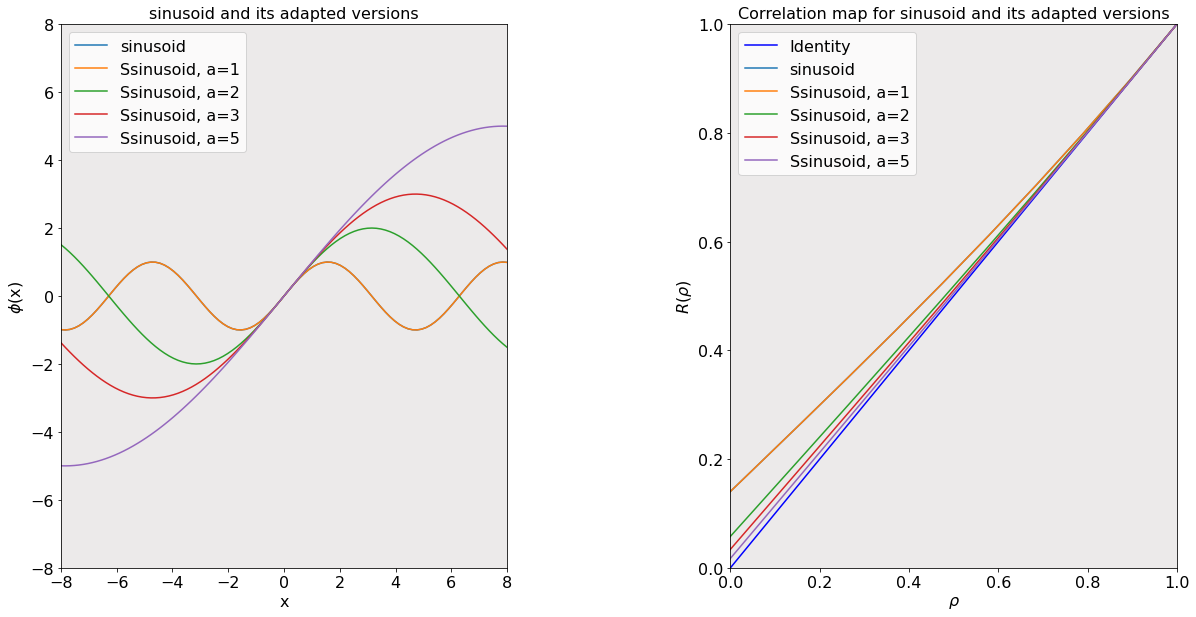

In [ ]:
# Call activation function you want to test
activation = 'sinusoid'

q_sin,vw_sin,r_sin,R_sin = analyze_phi(activation,params,a,vb,tol,max_iter,M,N,zlb,zub,xlb,xub)

Failed to converge to fixed point
Key statistics and values for relu :
Values of a: [1 2 3 5]
q*: [5.01000000e+02 2.00006104e-01 2.00006104e-01 2.00006104e-01
 2.00006104e-01]
vw: [2. 2. 2. 2. 2.]
r: [2. 2. 2. 2. 2.]


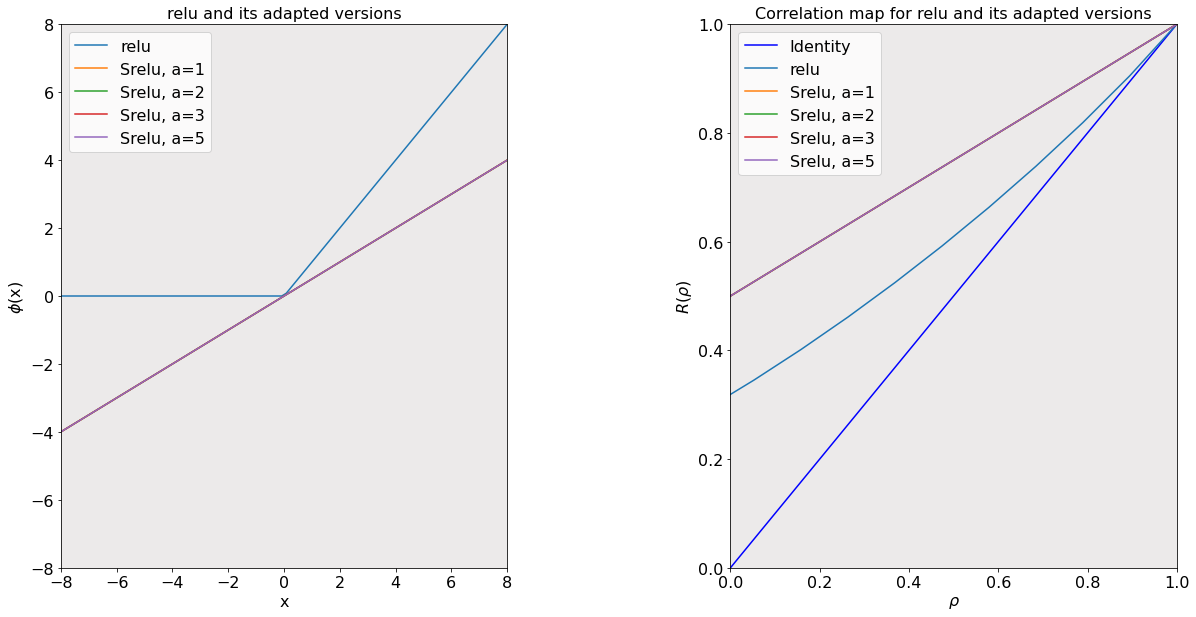

In [ ]:
# Call activation function you want to test
activation = 'relu'

q_gauss,vw_gauss,r_gauss,R_gauss = analyze_phi(activation,params,a,vb,tol,max_iter,M,N,zlb,zub,xlb,xub)

#Note that Variance map equation for ReLU is not satisfied unless bias=0

Key statistics and values for elu :
Values of a: [1 2 3 5]
q*: [2.21261106 0.86591312 1.50594447 2.13052839 3.35664424]
vw: [1.60673343 1.4765661  1.3636848  1.30664226 1.24496027]
r: [1.4593671  1.30968652 1.19656984 1.14653229 1.09877304]


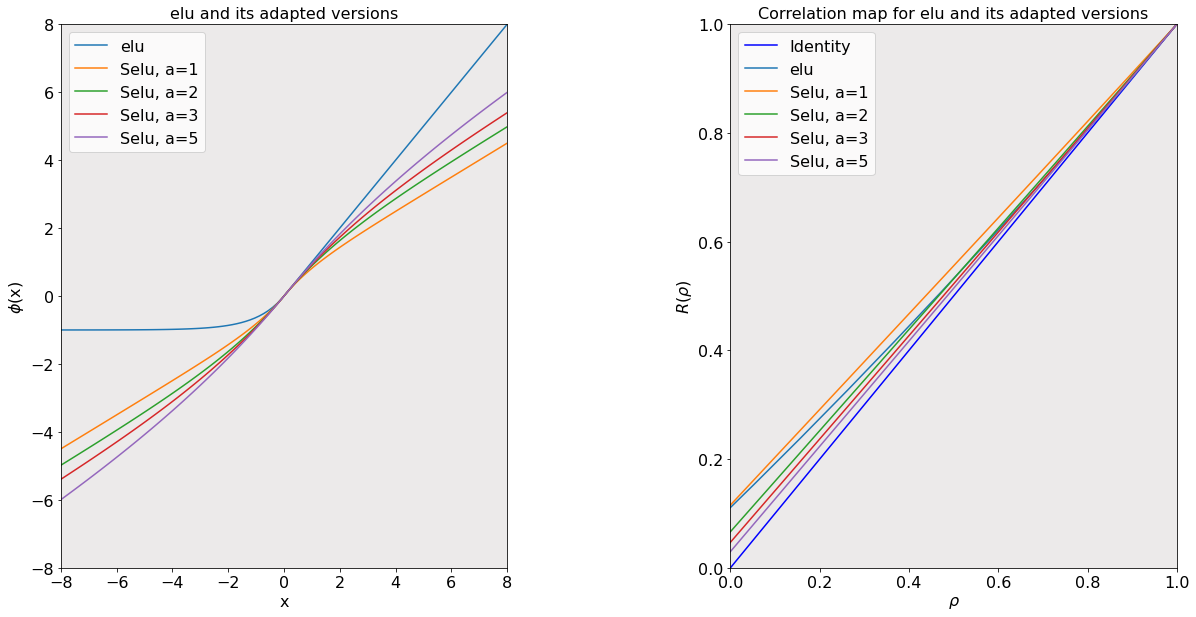

In [ ]:
# Call activation function you want to test
activation = 'elu'
params = np.array([1])

q_elu,vw_elu,r_elu,R_elu = analyze_phi(activation,params,a,vb,tol,max_iter,M,N,zlb,zub,xlb,xub)

## Visualization of new scaled activation functions

In [ ]:
act_string = 'h_saw'
phi = act_funcs[act_string]
diff_phi = diff_act_funcs[act_string]

# FOR PLOTS OF ACTIVATION FUNCTION
# Generate values for plotting activation function along with its symmetrized versions
a = [1,2,4]
M = 100
zlb = -8
zub = 8
z = np.linspace(zlb,zub,M)
num_tests = len(a)
f = np.zeros((num_tests, M))

for i in range(num_tests):
    for j in range(M):
        params = np.array([a[i]])
        f[i,j] = phi(z[j], params)

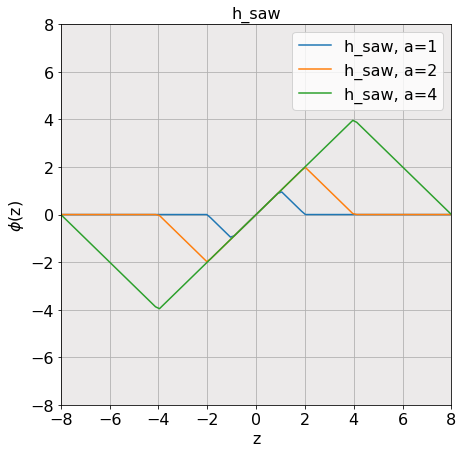

In [ ]:
plt.figure(figsize=(7,7))
for i in range(len(a)):
    plt.plot(z,f[i],label=act_string +', a=%s'%(a[i]))
plt.grid(True)
plt.title(act_string,fontsize=16)
plt.ylabel('$\phi$(z)',fontsize=16)
plt.xlabel('z',fontsize=16)
plt.xlim(zlb,zub)
plt.ylim(zlb,zub)
plt.xticks(fontsize=16 )
plt.yticks(fontsize=16 )
plt.legend(fontsize=16)

ax = plt.axes() 
ax.set_facecolor('#ECEAEA')
plt.show()

## Plot demonstrating Variance and Correlation function for a fixed bias variance

In [ ]:
# DEFINE COMMON PARAMETERS
#Set bias variance
vb = [0,0.1]

# q* calculation parameters
tol = 10**-5
max_iter = 5000

# Select activation function
activation_list = ['relu','tanh','elu']
param_list = [np.array([]),np.array([]),np.array([1])]

num_acts = len(activation_list)
num_vb = len(vb)

# Initialize arrays to hold vw, q* and r
q = np.zeros((num_vb, num_acts))
vw = np.zeros((num_vb, num_acts))
r = np.zeros((num_vb, num_acts))

# N sets number of points
N = 20
# Initialize arrays for correlation map
x = np.linspace(-1,1,N)
v = np.linspace(0,2,N)

V = np.zeros((num_vb, num_acts, N)) # Varaince 
R = np.zeros((num_vb, num_acts, N)) # Correlation

for k in range(num_vb):
    for i in range(num_acts):
            phi = act_funcs[activation_list[i]]
            diff_phi = diff_act_funcs[activation_list[i]]
            params = param_list[i]
            _,q[k,i],_ = q_star_decorator(phi,diff_phi,params,vb[k],tol,max_iter)
            vw[k,i]= vw_decorator(diff_phi,params,q[k,i])
            correlation_map = corr_map_decorator(phi,params,q[k,i],vw[k,i],vb[k])
            for j in range(N):
                V[k,i,j] = var_decorator(phi,params,v[j],vb[k],vw[k,i])
                R[k,i,j] = correlation_map(x[j])

Failed to converge to fixed point


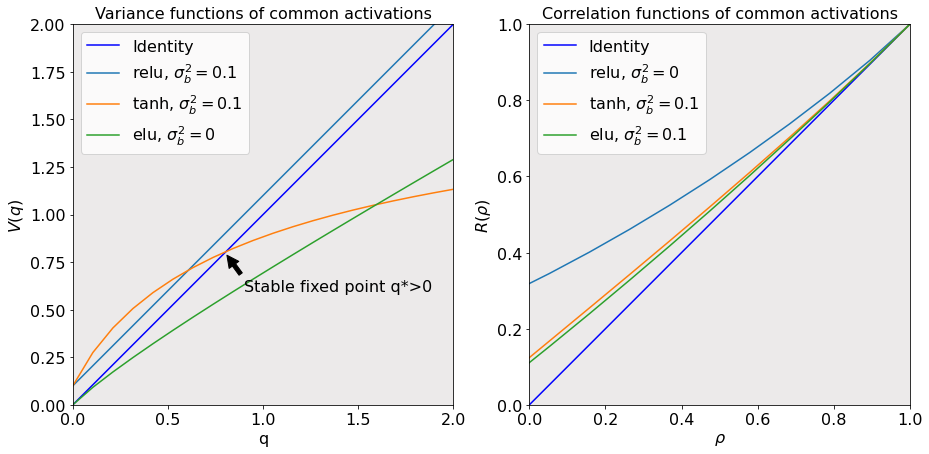

In [ ]:
# VARIANCE PLOT
vlb = 0
vub = 2

fig, ax = plt.subplots(1,2,figsize=(15,7))
ax[0].plot(v,v,color='blue', label = 'Identity')
ax[0].plot(v,V[1,0],label= activation_list[0] + ', $\sigma_b^2 = 0.1$')
ax[0].plot(v,V[1,1],label=activation_list[1] + ', $\sigma_b^2 = 0.1$')
ax[0].plot(v,V[0,2],label=activation_list[2] + ', $\sigma_b^2 = 0$')
ax[0].annotate('Stable fixed point q*>0', xy=(0.8, 0.8), xytext=(0.9, 0.6), arrowprops=dict(facecolor='black', shrink=0.1),fontsize=16)
ax[0].set_title('Variance functions of common activations',fontsize=16)
ax[0].set_ylabel(r'$V(q)$',fontsize=16)
ax[0].set_xlabel('q',fontsize=16)
ax[0].set_xlim(vlb,vub)
ax[0].set_ylim(vlb,vub)
ax[0].legend(fontsize=16)
ax[0].tick_params(axis='both', labelsize=16)
ax[0].set_facecolor('#ECEAEA')

# CORRELATION PLOT
xlb = 0
xub = 1
ax[1].plot(x,x,color='blue', label = 'Identity')
ax[1].plot(x,R[0,0],label=activation_list[0] + ', $\sigma_b^2 = 0$')
ax[1].plot(x,R[1,1],label=activation_list[1] + ', $\sigma_b^2 = 0.1$')
ax[1].plot(x,R[1,2],label=activation_list[2] + ', $\sigma_b^2 = 0.1$')
ax[1].set_title('Correlation functions of common activations',fontsize=16)
ax[1].set_ylabel(r'$R(\rho)$',fontsize=16)
ax[1].set_xlabel(r'$\rho$',fontsize=16)
ax[1].set_xlim(xlb,xub)
ax[1].set_ylim(xlb,xub)
ax[1].legend(fontsize=16)
ax[1].tick_params(axis='both', labelsize=16)
ax[1].set_facecolor('#ECEAEA')
plt.show()

## Plot demonstrating introduction of new fixed point


In [ ]:
act_string = 'htanh'
phi = act_funcs[act_string]
diff_phi = diff_act_funcs[act_string]

x = np.linspace(-1,1,N)
R = np.zeros((3, N))
vw = np.zeros(3)

In [ ]:
_,q,_ = q_star_decorator(phi,diff_phi,params,vb,tol,max_iter)
vw[0]= vw_decorator(diff_phi,params,q)
correlation_map = corr_map_decorator(phi,params,q,vw[0],vb)
for j in range(N):
    R[0,j] = correlation_map(x[j])


In [ ]:
vw[1] = 2*vw[0]
_,q1,_  = q_star_decorator_non_EOC(phi,diff_phi,params,vb,vw[1],tol,max_iter)
correlation_map = corr_map_decorator(phi,params,q1,vw[1],vb)
for j in range(N):
    R[1,j] = correlation_map(x[j])

In [ ]:
vw[2] = 0.5*vw[0]
_,q2,_  = q_star_decorator_non_EOC(phi,diff_phi,params,vb,vw[2],tol,max_iter)
correlation_map = corr_map_decorator(phi,params,q2,vw[2],vb)
for j in range(N):
    R[2,j] = correlation_map(x[j])

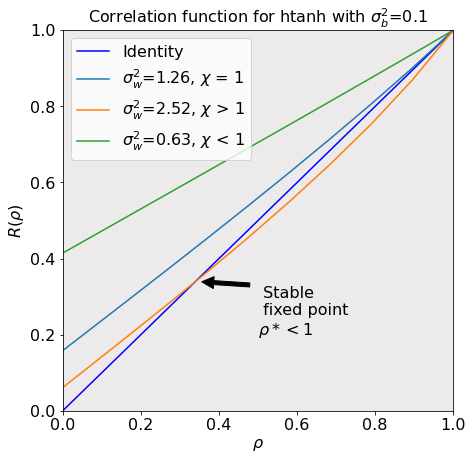

In [ ]:
# Plot correlation map for for htanh activation function with different weight variance
plt.figure(figsize=(7,7))
# Plot identity
plt.plot(x,x,color='blue', label = 'Identity')
plt.plot(x,R[0],label=r'$\sigma_w^2$=' + '%0.4s'%(vw[0]) + ', ' + r'$\chi$ = 1')
plt.plot(x,R[1],label=r'$\sigma_w^2$=' + '%0.4s'%(vw[1])+ ', ' + r'$\chi$ > 1')
plt.plot(x,R[2],label=r'$\sigma_w^2$=' + '%0.4s'%(vw[2])+ ', ' + r'$\chi$ < 1')

plt.title('Correlation function for ' + act_string + ' with ' + r'$\sigma_b^2$' + '=0.1' ,fontsize=16)
plt.annotate(' Stable \n fixed point \n'+ r'$\rho*<1$', xy=(0.34, 0.34), xytext=(0.5, 0.2), arrowprops=dict(facecolor='black', shrink=0.1),fontsize=16)
plt.ylabel(r'$R(\rho)$',fontsize=16)
plt.xlabel(r'$\rho$',fontsize=16)
plt.xlim(0,1)
plt.ylim(0,1)
plt.legend(loc="upper left",fontsize=16)
plt.xticks(fontsize=16 )
plt.yticks(fontsize=16 )
ax = plt.axes() 
ax.set_facecolor('#ECEAEA')
plt.show()

## Analysis of htanh:

Key statistics and values for htanh :
Values of a: [1 2 3 5]
q*: [0.63217251 0.63217251 1.41310433 2.41053311 4.98510212]
vw: [1.26341572 1.26341572 1.1019054  1.05633196 1.02577723]
r: [1.26341573 1.26341573 1.1019054  1.05633196 1.02577723]


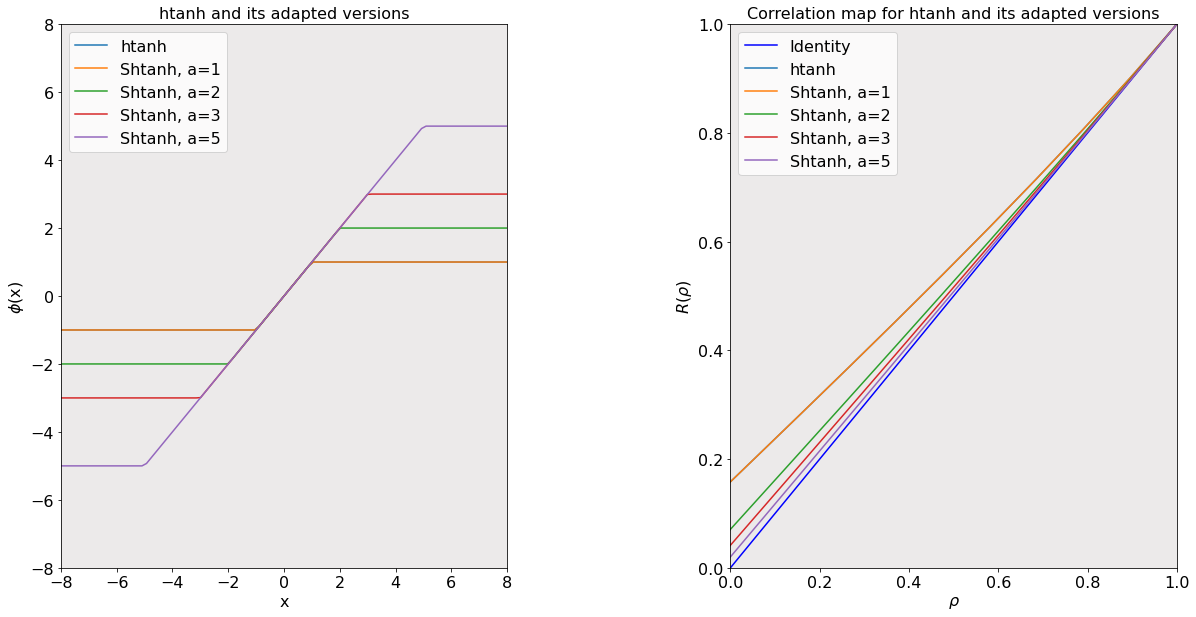

In [ ]:
# Define activation function want to test
activation = 'htanh'

q_htanh,vw_htanh,r_htanh,R_htanh = analyze_phi(activation,params,a,vb,tol,max_iter,M,N,zlb,zub,xlb,xub)

In [ ]:
# Compute R(0) for htanh for a wide range of a values
activation = 'htanh'
phi = act_funcs[activation]
diff_phi = diff_act_funcs[activation]

# Select range of scales to test   # Note this will modify presets from earier cell in this notebook
a = np.linspace(1,40,40)

# Compute calculated bound
upper_bound_derived = ((2/np.pi)*(vb/a**2))**(1/3)
upper_bound_observed = ((2/np.pi)*(vb/a**3))**(1/3)


In [ ]:
# Compute q* for different values of a
q_stars = np.zeros(len(a))
# Compute q* for each value of a
for i in range(len(a)):
    _,q_stars[i],_ = q_star_decorator(scale_symm_decorator(phi,params,a[i]),diff_scale_symm_decorator(diff_phi,params,a[i]),params,vb,tol,max_iter)

In [ ]:
# Calculate ratio a/sqrt(q)
a_over_sqrtq = np.zeros(len(a))
for i in range(len(a)):
    a_over_sqrtq[i] = a[i]/np.sqrt(q_stars[i])

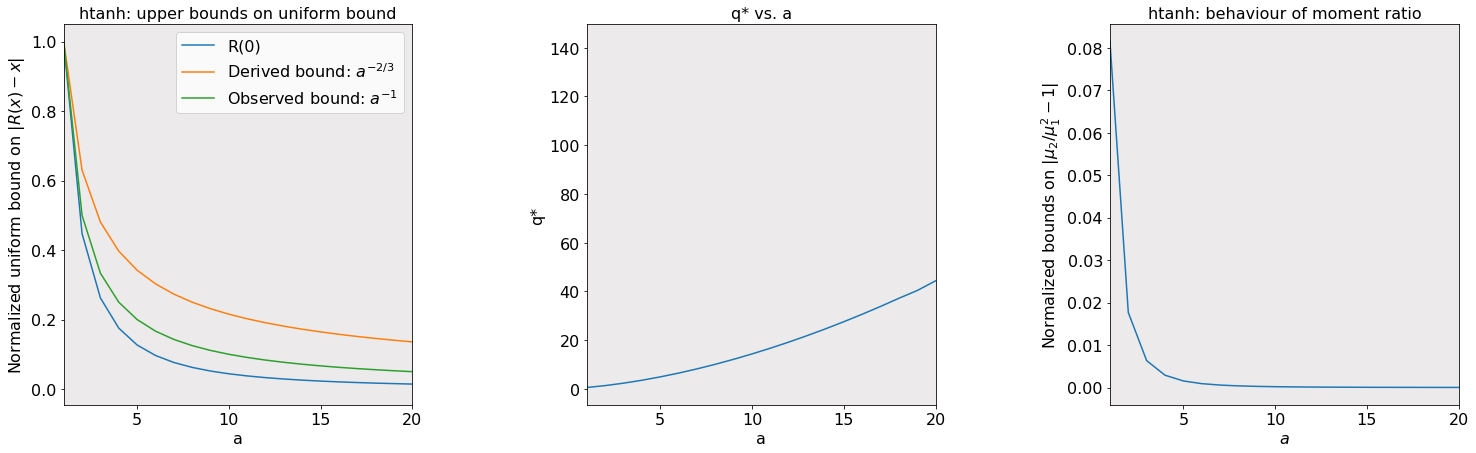

In [ ]:
# Plot bound on gap between identity and correlation map.
R_0 = vb/q_stars
fig, ax = plt.subplots(1,3,figsize=(25,7))

ax[0].plot(a,R_0/R_0[0],label='R(0)')
ax[0].plot(a,upper_bound_derived/upper_bound_derived[0],label='Derived bound: $a^{-2/3}$')
ax[0].plot(a,upper_bound_observed/upper_bound_observed[0],label='Observed bound: $a^{-1}$')
ax[0].set_title('htanh: upper bounds on uniform bound',fontsize=16)
ax[0].set_ylabel('Normalized uniform bound on $|R(x)-x|$',fontsize=16)
ax[0].set_xlabel('a',fontsize=16)
ax[0].set_xlim(1,20)
ax[0].tick_params(axis='both', labelsize=16)
ax[0].legend(fontsize=16)
ax[0].set_facecolor('#ECEAEA')


# Plot q^* vs a
ax[1].plot(a,q_stars)
ax[1].set_title('q* vs. a',fontsize=16)
ax[1].set_ylabel('q*',fontsize=16)
ax[1].set_xlabel('a',fontsize=16)
ax[1].set_xlim(1,20)
ax[1].tick_params(axis='both', labelsize=16)
ax[1].set_facecolor('#ECEAEA')


# Plot moment ratio
sigma_JJ = 1/special.erf(a_over_sqrtq)

ax[2].plot(a,(sigma_JJ-1))
ax[2].set_title('htanh: behaviour of moment ratio', fontsize=16)
ax[2].set_ylabel('Normalized bounds on $|\mu_2 / \mu_1^2-1|$',fontsize=16)
ax[2].set_xlabel('$a$',fontsize=16)
ax[2].set_xlim(1,20)
ax[2].tick_params(axis='both', labelsize=16) 
ax[2].set_facecolor('#ECEAEA')

fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.5) 
plt.show()

## Numerics for theory

In [ ]:
# DEFINE COMMON PARAMETERS
tol = 10**-5
max_iter = 10000
vb = 0.1
tol = 10**-5
# Select range of scales to test
a = np.linspace(1,10,10)

In [ ]:
# Generate curves for hard tanh
activation = 'h_tanh'
params = np.array([])

q_h_tanh,l_h_tanh,vw_h_tanh,r_h_tanh,R0_h_tanh = compute_key_stats(activation,vb,a,tol,max_iter)

In [ ]:
# Generate curves for hard sine
activation = 'h_sine'
params = np.array([])

q_h_sine,l_h_sine,vw_h_sine,r_h_sine,R0_h_sine =compute_key_stats(activation,vb,a,tol,max_iter)

In [ ]:
# Generate curves for hard exp
activation = 'h_exp'
params = np.array([])

q_h_exp,l_h_exp,vw_h_exp,r_h_exp,R0_h_exp = compute_key_stats(activation,vb,a,tol,max_iter)

In [ ]:
# Generate curves for hard saw
activation = 'h_saw'
params = np.array([])

q_h_saw,l_h_saw,vw_h_saw,r_h_saw,R0_h_saw = compute_key_stats(activation,vb,a,tol,max_iter)

**Analysis of length ratio bounds**

In [ ]:
# Compute lower bound
y = vb/a**2
delta = np.sqrt(special.lambertw((2/np.pi)*y**(-2)))
beta = np.sqrt(2/np.pi)*np.exp(-0.5*delta**2)*(delta + (2/delta))
linear_size_lb = np.real(np.sqrt(special.lambertw((2/np.pi)*(beta**(-2)))))

# Compute upper bound
linear_size_ub = ((8/np.pi)**(1/3))*y**(-1/3)    

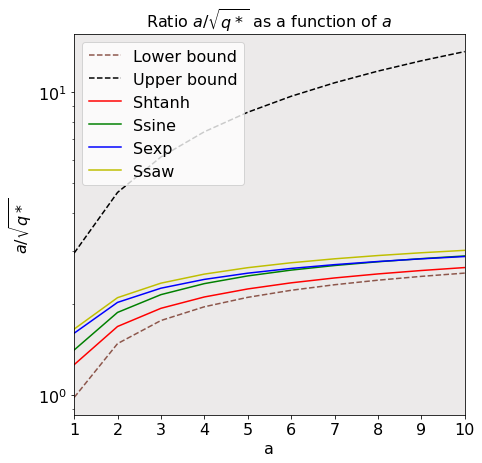

In [ ]:
plt.figure(figsize=(7,7))
plt.plot(a,linear_size_lb,'--',color='tab:brown',label='Lower bound')
plt.plot(a,linear_size_ub,'--',color='k',label='Upper bound')
plt.plot(a,l_h_tanh ,color='r',label='Shtanh')
plt.plot(a,l_h_sine ,color='g',label='Ssine')
plt.plot(a,l_h_exp,color='b',label='Sexp')
plt.plot(a,l_h_saw,color='y',label='Ssaw')
plt.title('Ratio $a/\sqrt{q*}$ as a function of $a$',fontsize=16)
plt.ylabel('$a/\sqrt{q*}$',fontsize=16)
plt.yscale('log')
plt.xlabel('a',fontsize=16)
plt.xlim(1,10)
plt.xticks(fontsize=16 )
plt.yticks(fontsize=16 )
plt.legend(fontsize=16)

ax = plt.axes() 
ax.set_facecolor('#ECEAEA')
plt.show()

**Analysis of correlation bound**

In [ ]:
# Compute upper bound
corr_ub = ((8/np.pi)**(1/3))*y**(1/3)

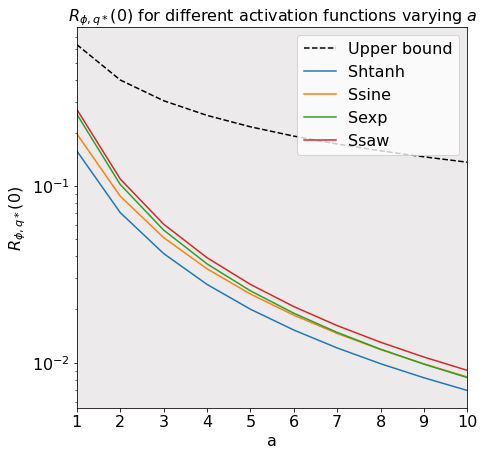

In [ ]:
plt.figure(figsize=(7,7))
plt.plot(a,corr_ub,'--',color='k',label='Upper bound')
plt.plot(a,R0_h_tanh ,label='Shtanh')
plt.plot(a,R0_h_sine ,label='Ssine')
plt.plot(a,R0_h_exp,label='Sexp')
plt.plot(a,R0_h_saw,label='Ssaw')

plt.title('$R_{\phi, q*}(0)$ for different activation functions varying $a$',fontsize=16)
plt.ylabel('$R_{\phi, q*}(0)$',fontsize=16)
plt.yscale('log')
plt.xlabel('a',fontsize=16)
plt.xlim(1,10)
plt.legend(loc="upper right",fontsize=16)
plt.xticks(fontsize=16 )
plt.yticks(fontsize=16 )
ax = plt.axes() 
ax.set_facecolor('#ECEAEA')
plt.show()

**Analysis of dynamical isometry bound**

In [ ]:
# Compute upper bound
di_upper_bound = (special.erf(linear_size_lb/np.sqrt(2)))**(-2) - 1

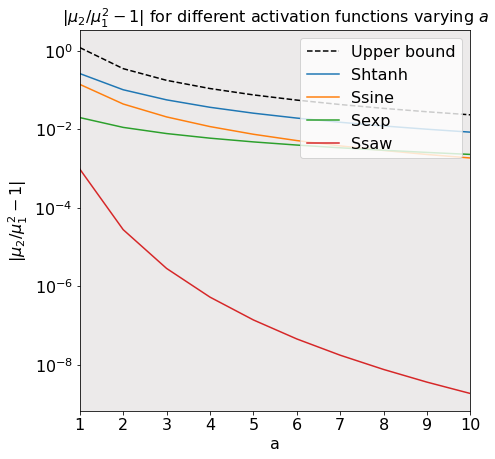

In [ ]:
plt.figure(figsize=(7,7))
plt.plot(a,di_upper_bound,'--',color='k',label='Upper bound')
plt.plot(a,np.abs(r_h_tanh-1*np.ones(len(a))) ,label='Shtanh')
plt.plot(a,np.abs(r_h_sine-1*np.ones(len(a))) ,label='Ssine')
plt.plot(a,np.abs(r_h_exp-1*np.ones(len(a))),label='Sexp')
plt.plot(a,np.abs(r_h_saw-1*np.ones(len(a))),label='Ssaw')
plt.title('$|\mu_2/\mu_1^2-1|$ for different activation functions varying $a$',fontsize=16)
plt.ylabel('$|\mu_2/\mu_1^2 - 1|$',fontsize=16)
plt.xlabel('a',fontsize=16)
plt.yscale('log')
plt.xlim(1,10)
plt.legend(loc="upper right",fontsize=16)
plt.xticks(fontsize=16 )
plt.yticks(fontsize=16 )
ax = plt.axes() 
ax.set_facecolor('#ECEAEA')
plt.show()

## Lower bound $\gamma$ for $\frac{a}{\sqrt{q^*}}$, given a value of $y = \sigma_b^2/a^2$

In [ ]:
K = 1.1
x = np.linspace(0,4,100)
h = K*special.erfc(x/np.sqrt(2)) + 0.25
g = np.sqrt(2/np.pi)*np.exp(-0.5*x**2)/x


Delta = np.real(np.sqrt(special.lambertw((2/np.pi)*0.25**(-2))))
m = -np.sqrt(2/np.pi)*np.exp(-0.5*(Delta**2))*(Delta**(-2)+1)
c = np.sqrt(2/np.pi)*np.exp(-0.5*Delta**2)*(Delta + (2/Delta))
u = m*x + c
gamma = np.real(np.sqrt(special.lambertw((2/np.pi)*c**(-2))))

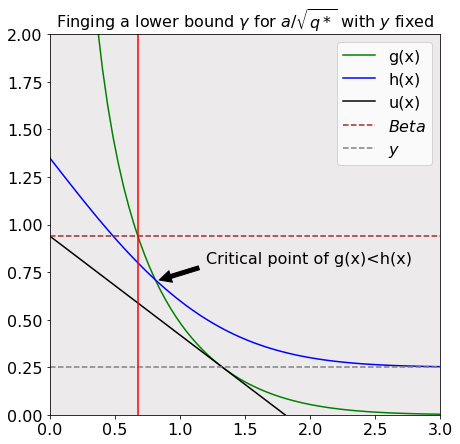

In [ ]:
plt.figure(figsize=(7,7))
plt.plot(x,g, color='g', label='g(x)')
plt.plot(x,h, color='b',label='h(x)')
plt.plot(x,u, color='k',label='u(x)')
plt.plot(x,c*np.ones(len(x)), '--', color='brown',label='$Beta$')
plt.plot(x,0.25*np.ones(len(x)), '--', color='gray',label='$y$')
plt.axvline(x=gamma,color='red')

plt.title('Finging a lower bound $\gamma$ for $a/\sqrt{q*}$ with $y$ fixed',fontsize=16)
plt.annotate('Critical point of g(x)<h(x)', xy=(0.8, 0.7), xytext=(1.2, 0.8),
             arrowprops=dict(facecolor='black', shrink=0.1),fontsize=16
             )
# plt.xlabel('$')
plt.xlim(0,3)
plt.ylim(0,2)
plt.legend(loc="upper right",fontsize=16)
plt.xticks(fontsize=16 )
plt.yticks(fontsize=16 )
ax = plt.axes() 
ax.set_facecolor('#ECEAEA')
plt.show()

## Numerics for theory (Extended)

Any activation function from class $\Omega$ are special due to their ability to avoiding problems at initialisation that can stall or slowdown network training. Here, we show that a simple transformation (although not universal) can be used to achieve similar properties as defined for activation class $\Omega$. One such transformation is implemented as '*scale_symm_decorator()*' and here we demonstrate this phenomena using tanh and elu activation functions.

In [ ]:
tol = 10**-5
max_iter = 7000
vb = 0.1
tol = 10**-5
# Select range of scales to test
a = np.linspace(1,20,40)

In [ ]:
# Compute q* and moment ratio
def compute_key_stats1(act_string,params,vb,a,tol,max_iter):
    phi = act_funcs[act_string]
    diff_phi = diff_act_funcs[act_string]
    
    q = np.zeros(len(a)+1)
    l = np.zeros(len(a))
    vw = np.zeros(len(a)+1)
    r = np.zeros(len(a)+1)   
    R0 = np.zeros(len(a)+1)
       
    _,q[0],_ = q_star_decorator(phi,diff_phi,params,vb,tol,max_iter)
    vw[0]= vw_decorator(diff_phi,params,q[0])
    r[0] = r_decorator(diff_phi,params,q[0])
    correlation_map = corr_map_decorator(phi,params,q[0],vw[0],vb)
    R0[0] = correlation_map(0)
    
    for i in range(len(a)):
        _,q[i+1],_ = q_star_decorator(scale_symm_decorator(phi,params,a[i]),diff_scale_symm_decorator(diff_phi,params,a[i]),params,vb,tol,max_iter)
        l[i] = a[i]/np.sqrt(q[i+1])
        vw[i+1]= vw_decorator(diff_scale_symm_decorator(diff_phi,params,a[i]),params,q[i+1])
        r[i+1] = r_decorator(diff_scale_symm_decorator(diff_phi,params,a[i]),params,q[i+1])
        correlation_map = corr_map_decorator(scale_symm_decorator(phi,params,a[i]),params,q[i+1],vw[i+1],vb)
        R0[i+1] = correlation_map(0)
    return q,l,vw,r,R0

In [ ]:
# Generate curves for tanh
activation = 'tanh'
params = np.array([])

q_tanh,l_tanh,vw_tanh,r_tanh,R0_tanh = compute_key_stats1(activation,params,vb,a,tol,max_iter)


In [ ]:
# Generate curves for elu
activation = 'elu'
params = np.array([1])

q_elu,l_elu,vw_elu,r_elu,R0_elu = compute_key_stats1(activation,params,vb,a,tol,max_iter)

**Analysis of length ratio, correlation and dynamical isometry bounds**

In [ ]:
# Compute lower bound
y = vb/a**2
delta = np.sqrt(special.lambertw((2/np.pi)*y**(-2)))
beta = np.sqrt(2/np.pi)*np.exp(-0.5*delta**2)*(delta + (2/delta))
linear_size_lb = np.real(np.sqrt(special.lambertw((2/np.pi)*(beta**(-2)))))

# Compute upper bound
linear_size_ub = ((8/np.pi)**(1/3))*y**(-1/3)  

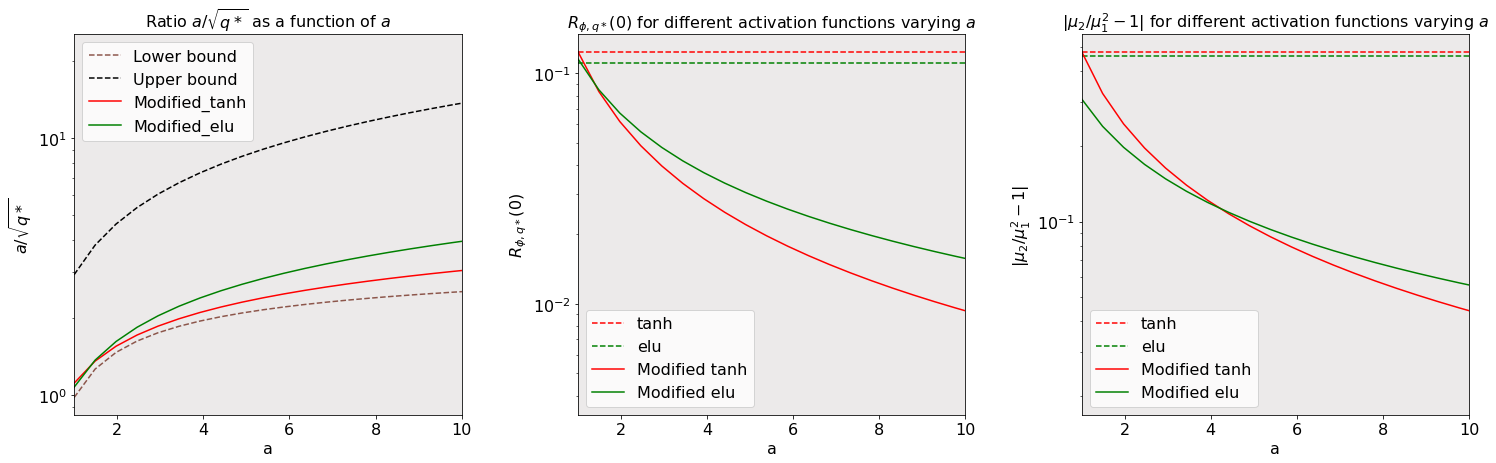

In [ ]:
fig, ax = plt.subplots(1,3,figsize=(25,7))
ax[0].plot(a,linear_size_lb,'--',color='tab:brown',label='Lower bound')
ax[0].plot(a,linear_size_ub,'--',color='k',label='Upper bound')
ax[0].plot(a,l_tanh ,color='r',label='Modified_tanh')
ax[0].plot(a,l_elu ,color='g',label='Modified_elu')
ax[0].set_title('Ratio $a/\sqrt{q*}$ as a function of $a$',fontsize=16)
ax[0].set_ylabel('$a/\sqrt{q*}$',fontsize=16)
ax[0].set_yscale('log')
ax[0].set_xlabel('a',fontsize=16)
ax[0].set_xlim(1,10)
ax[0].legend(fontsize=16)
ax[0].tick_params(axis='both', labelsize=16)
ax[0].set_facecolor('#ECEAEA')

ax[1].plot(a,R0_tanh[0]*np.ones(len(a)),'--', color='r', label='tanh')
ax[1].plot(a,R0_elu[0]*np.ones(len(a)),'--', color='g',label='elu')
ax[1].plot(a,R0_tanh[1:],color='r',label='Modified tanh')
ax[1].plot(a,R0_elu[1:],color='g',label='Modified elu')
ax[1].set_title('$R_{\phi, q*}(0)$ for different activation functions varying $a$',fontsize=16)
ax[1].set_ylabel('$R_{\phi, q*}(0)$',fontsize=16)
ax[1].set_yscale('log')
ax[1].set_xlabel('a',fontsize=16)
ax[1].set_xlim(1,10)
ax[1].legend(fontsize=16)
ax[1].tick_params(axis='both', labelsize=16)
ax[1].set_facecolor('#ECEAEA')

ax[2].plot(a,r_tanh[0]-1*np.ones(len(a)),'--', color='r', label='tanh')
ax[2].plot(a,r_elu[0]-1*np.ones(len(a)),'--', color='g',label='elu')
ax[2].plot(a,r_tanh[1:]-1*np.ones(len(a)),color='r',label='Modified tanh')
ax[2].plot(a,r_elu[1:]-1*np.ones(len(a)),color='g',label='Modified elu')
ax[2].set_title('$|\mu_2/\mu_1^2-1|$ for different activation functions varying $a$',fontsize=16)
ax[2].set_ylabel('$|\mu_2/\mu_1^2 - 1|$',fontsize=16)
ax[2].set_xlabel('a',fontsize=16)
ax[2].set_yscale('log')
ax[2].set_xlabel('a',fontsize=16)
ax[2].set_xlim(1,10)
ax[2].legend(fontsize=16)
ax[2].tick_params(axis='both', labelsize=16)
ax[2].set_facecolor('#ECEAEA')

fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.3)
plt.show()